## Lab 5.1 - Keras for CNN

In this lab we will use the [Keras deep learning library](https://keras.io/) to construct a simple convolutional neural network (CNN) to classify the digits from the MNIST dataset. Keras is a very high-level machine learning library that wraps many of the functions and data formats we developed from scratch in earlier labs into simple, easy to use functions. Infact, the library does not actually implement any computation itself, but borrows the necessary functions from either the TensorFlow or Theano libraries. Thus, the goal of Keras is not to compete with these state-of-the-art machine learning libraries, but simply to make them easier to use, especially for non-expert users.

As a result, you can see that this week's code, despite representing a more complex network, is actually much shorter and easier to understand. This ease of use has made Keras quite popular for neural network development in recent years. The tradeoff to this ease of use is that, while Keras implements many typical machine learning processes and methods, much of its funcitonality is hidden from the user. Thus, it is harder to access the model's parameters, investigate what is happening during model training, and to implement custom features such as your own activation and cost functions. In short, higher level libraries such as Keras may be easier to use for typical tasks, but they are harder to hack and use in non-typical ways.

We will be using Keras to develop more complex neural networks for the rest of the course, but as you develop your own applications you may want or need to go back to more low-level implementations such as in basic numpy or a medium-level library such as Tensorflow.

Let's begin this week's lab by importing the libraries we will be using:

In [15]:
import numpy as np
np.random.seed(1337)  # for reproducibility

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K

from keras.datasets import mnist

import pickle

print "using ordering:", K.image_dim_ordering()

using ordering: tf


After you import the Keras library you should see a message telling you whether it is using the Theano or Tensorflow library as its backend. Because it relies on one of these libraries to perform its calculations, you need to have at least one of them installed to use Keras. If you are using the virtual machine from the first tutorial you should already have both installed, and for our purposes it does not matter which Keras is configured to use.

Next, let's import the MNIST dataset from Keras' data library:

In [16]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print 'X_train shape:', X_train.shape
print X_train.shape[0], 'train samples'
print X_test.shape[0], 'test samples'

X_train shape: (60000, 28, 28)
60000 train samples
10000 test samples


The data comes in as separate variables for feature (X) and target (y) data, and is already split between training and test sets.

The format for the X data is a three-dimensional numpy array of integers. The first dimension represents the individual images, and the second and third dimensions represent the grayscale pixels values of each 28x28 image. The pixel values are represented as integers in the range 0-255. The y data contains a list of single integers representing the type of digit 0-9.

Before we can use this data for training, we need to convert the integer (whole number) numbers in the range 0-255 to float (decimal) numbers in the range 0-1. We do this by casting the numpy arrays to 'float' type, and dividing each value by 255.

In [17]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0

To use this data with Keras we also need to reformat it to match the specific needs of the library. Because Keras' convolutional operations are made specifically for processing images, they expect each piece of image data to be represented by three dimensions: two for the dimensions of the image, and an extra dimension to represent the RGB channels of a full-color image. 

Since in this case we are working with black and white images, we will simply add an extra dimension to the end of both X datasets so it matches the expected format. We will also use the `to_categorical()` utility included with the Keras library to convert both of the y datasets to the categorical format expected by Keras.

In [18]:
# number of classes
num_classes = 10

# image dimensions
img_rows, img_cols = X_train.shape[1],  X_train.shape[2]

if K.image_dim_ordering() == 'th':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

Y_train = np_utils.to_categorical(y_train, num_classes)
Y_test = np_utils.to_categorical(y_test, num_classes)

print X_train.shape
print y_train.shape

(60000, 28, 28, 1)
(60000,)


Before we begin training the network, we can use the matplotlib library to visualize one of the digits to make sure everything has been loaded correctly.

(28, 28)
(60000,)


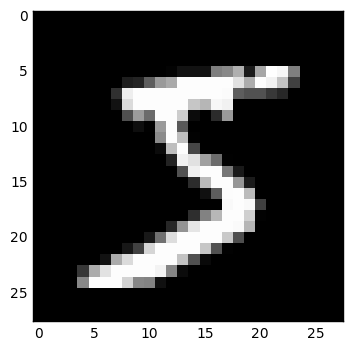

In [19]:
%matplotlib inline
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

img_num = 0

if K.image_dim_ordering() == 'th':
    img = X_train[img_num][0,:,:]
else:
    img = X_train[img_num][:,:,0]

print img.shape
print y_train.shape
imshow(img, cmap = plt.get_cmap('gray'), vmin = 0, vmax = 1,  interpolation='nearest')

Now we define the hyper-parameters of our model and the architecture of the network. In this case we will base our network on the one described in chapter 6 of the textbook:

http://neuralnetworksanddeeplearning.com/chap6.html

This is a fairly shallow CNN model utilizing two convolutional layers with 2x2 max pooling for data reduction, and two fully connected layers with 50% dropout for regularization. All layers except for the final classification layer utilize the ReLu activation function. The final layer uses the softmax activation function to convert the raw outputs to a probability distribution. The layers have the following dimensions:

- The first convolutional layer will use a patch (filter) size of 5 x 5 pixels, and a depth of 20 feature layers
- The second convolutional layer will use a patch (filter) size of 5 x 5 pixels, and a depth of 40 feature layers
- The two fully connected hidden layers will each contain 1000 neurons

We will train the model for 30 epochs, using mini-batches of 128 samples at a time with the SGD algorithm.

In [20]:
# model hyperparameters
batch_size = 128
nb_epoch = 30

# network architecture
patch_size_1 = 5
patch_size_2 = 5

depth_1 = 20
depth_2 = 40

pool_size = 2

num_hidden_1 = 1000
num_hidden_2 = 1000

dropout = 0.5

Now it is time to build the actual model in Keras. To specify the architecture of the neural network, Keras uses an abstracted sequential or 'stack' model. Instead of specifying each step of computation as we did with numpy and Tensorflow, we simply create a new Sequential model, and then use its `.add()` function to add layers to the network according to the parameters specified above.

In [21]:
# create new Keras Sequential model
model = Sequential()

# add first convolutional layer to model and specify it's depth and filter size
# for the first layer we also have to specify the size of each input image
# which we calculated above
model.add(Convolution2D(depth_1, patch_size_1, patch_size_1,
                        border_mode='valid',
                        input_shape=input_shape))
# apply 'relu' activation function for first layer
model.add(Activation('relu'))
# apply max pooling to reduce the size of the image by a factor of 2
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

# repeat these operations for the second convolutional layer
# this time Keras can figure out the input size 
# from the previous layer on it's own
model.add(Convolution2D(depth_2, patch_size_2, patch_size_2,
                        border_mode='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

# flatten the three-dimensional convolutional layer to a single layer of neurons
model.add(Flatten())

# add the first fully connected layer, applying 'relu' activation and dropout
model.add(Dense(num_hidden_1))
model.add(Activation('relu'))
model.add(Dropout(dropout))

# add the second fully connected layer
model.add(Dense(num_hidden_2))
model.add(Activation('relu'))
model.add(Dropout(dropout))

# add the final classification layer with the number of neurons 
# matching the number of classes we are trying to learn
model.add(Dense(num_classes))

# apply the 'softmax' activation to the final layer to convert the output to 
# a probability distribution
model.add(Activation('softmax'))

Next, we ask Keras to compile our model, and specify the loss function we want to use, along with the optimization algorithm and the performance metrics we want the model to output after training. You can see that this is much easier and more intuitive than our previous examples where we had to actually write out the forumulas for the loss function and explicitly develop the optimization algorithm. However, if you wanted to use a different loss function or optimization strategy than those already included with Keras you would again have to specify it explicitly using additional functions.

In [22]:
model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

Once we have compiled the model, we can begin training. The entire training operation  is now wrapped into a single function called `.fit()`. Instead of creating our own structure to loop over every epoch and mini-batch, we simply have to call the `.fit()` function of our Sequential model, and pass in our training and test sets, along with the hyper-parameters that specify the number of epochs and mini-batch size we want to use. If you set the optional `verbose` variable to `1`, Keras will output information about loss and accuracy on both training and test sets as it is training so you can monitor the process.

In [23]:
model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
          verbose=1, validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 77s - loss: 0.2917 - acc: 0.9079 - val_loss: 0.0636 - val_acc: 0.9803
Epoch 2/30
60000/60000 [==============================] - 73s - loss: 0.0793 - acc: 0.9756 - val_loss: 0.0410 - val_acc: 0.9855
Epoch 3/30
60000/60000 [==============================] - 81s - loss: 0.0565 - acc: 0.9825 - val_loss: 0.0308 - val_acc: 0.9896
Epoch 4/30
60000/60000 [==============================] - 90s - loss: 0.0456 - acc: 0.9859 - val_loss: 0.0258 - val_acc: 0.9914
Epoch 5/30
60000/60000 [==============================] - 104s - loss: 0.0375 - acc: 0.9886 - val_loss: 0.0247 - val_acc: 0.9914
Epoch 6/30
60000/60000 [==============================] - 97s - loss: 0.0313 - acc: 0.9902 - val_loss: 0.0238 - val_acc: 0.9921
Epoch 7/30
60000/60000 [==============================] - 101s - loss: 0.0275 - acc: 0.9915 - val_loss: 0.0261 - val_acc: 0.9910
Epoch 8/30
60000/60000 [============================

Depending on the computer you're using, training this network through 30 epochs will take some time. Using the virtual machine from Lab 1, each epoch takes approximately 40-50 seconds. Once the training is complete, we can use the model's `.evaluate()` function to apply the model to the entire test set, and get back the model's performance in terms of total loss and prediction accuracy.

In [24]:
score = model.evaluate(X_test, Y_test, verbose=0)

print 'Test score:', score[0]
print 'Test accuracy: {:.2%}'.format(score[1])

Test score: 0.0231376923458
Test accuracy: 99.40%
